In [1]:
%uv pip install wandb pycocotools kagglehub huggingface_hub bitsandbytes wandb[media]

Using Python 3.12.6 environment at: /usr/local
Resolved 73 packages in 184ms
⠙ Preparing packages... (0/13)
⠙ Preparing packages... (0/13)
⠙ Preparing packages... (0/13)
smmap      ------------------------------     0 B/23.73 KiB
⠙ Preparing packages... (0/13)
smmap      ------------------------------ 14.88 KiB/23.73 KiB
⠙ Preparing packages... (0/13)
smmap      ------------------------------ 14.88 KiB/23.73 KiB
gitdb      ------------------------------     0 B/61.32 KiB
⠙ Preparing packages... (0/13)
smmap      ------------------------------ 14.88 KiB/23.73 KiB
gitdb      ------------------------------ 14.91 KiB/61.32 KiB
⠙ Preparing packages... (0/13)
smmap      ------------------------------ 14.88 KiB/23.73 KiB
gitdb      ------------------------------ 14.91 KiB/61.32 KiB
kagglehub  ------------------------------     0 B/66.66 KiB
⠙ Preparing packages... (0/13)
smmap      ------------------------------ 14.88 KiB/23.73 KiB
gitdb      ------------------------------ 14.91 KiB/61.32 KiB

In [2]:
%%bash
hf auth login --token $HF_TOKEN

# mkdir -p /mnt/coco/data
# mkdir -p /mnt/coco/models

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `UploadDINO` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


📂 Loading COCO from /mnt/coco/data/annotations/instances_val2017.json
loading annotations into memory...
Done (t=1.37s)
creating index...
index created!
🧾 img_id=26926
🧾 prompt=A photorealistic high quality image of car, fire hydrant
⏳ Loading SD ControlNet (image) pipeline...


config.json: 0.00B [00:00, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

⏳ Loading AnimateDiff + ControlNet (video) pipeline...


config.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

The config attributes {'motion_activation_fn': 'geglu', 'motion_attention_bias': False, 'motion_cross_attention_dim': None} were passed to MotionAdapter, but are not expected and will be ignored. Please verify your config.json configuration file.


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Keyword arguments {'safety_checker': None} are not expected by AnimateDiffControlNetPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

✅ Using AnimateDiffControlNetPipeline
🔎 Video pipeline control kwarg detected: conditioning_frames


  0%|          | 0/20 [00:00<?, ?it/s]

🎬 Saved video to: ./debug_out/animatediff_controlnet_singlemask.mp4


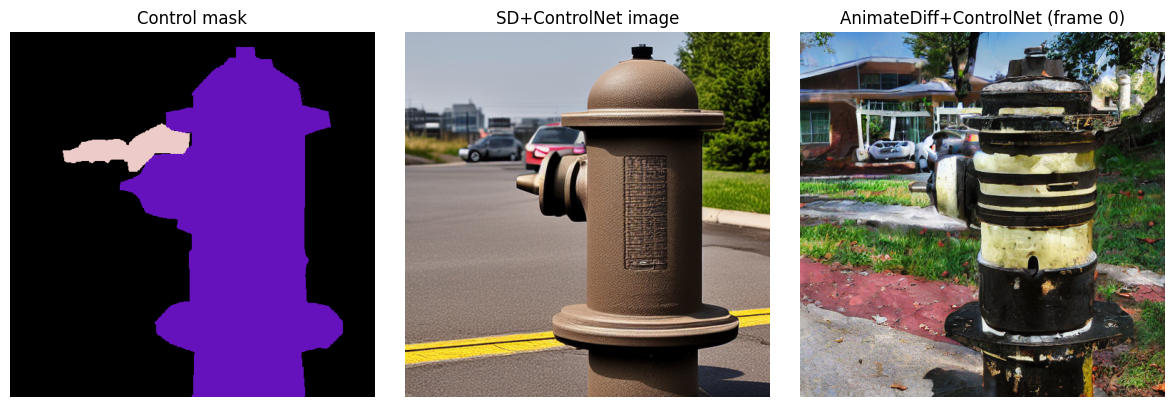

In [3]:
import os
import random
import hashlib
import inspect
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO

from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler,
    MotionAdapter,
)
from diffusers.utils import export_to_video

# -------------------
# CONFIG
# -------------------
BASE_PATH = "/mnt/coco/data"
ANN_FILE = os.path.join(BASE_PATH, "annotations/instances_val2017.json")
IMG_DIR  = os.path.join(BASE_PATH, "val2017")
if not os.path.exists(ANN_FILE):
    print(f"⚠️ Missing val set at {ANN_FILE}; falling back to train.")
    ANN_FILE = os.path.join(BASE_PATH, "annotations/instances_train2017.json")
    IMG_DIR  = os.path.join(BASE_PATH, "train2017")

MODEL_ID       = "runwayml/stable-diffusion-v1-5"
CONTROLNET_ID  = "ritishshrirao/Controlnet_SD1.5_coco_segmentation"
MOTION_ADAPTER = "guoyww/animatediff-motion-adapter-v1-5-2"

# If you trained motion modules and want to test them, set this:
MOTION_MODULE_PATH = None  # e.g. "/mnt/coco/models/.../checkpoint-500"

DEVICE = "cuda"
DTYPE  = torch.bfloat16

NUM_FRAMES = 8
H = W = 512
SEED = 42
NEG = "cartoon, drawing, low quality, bad quality, distorted, blurry"

# -------------------
# Helpers
# -------------------
def get_md5_palette(coco):
    palette = {}
    for cat in coco.loadCats(coco.getCatIds()):
        h = hashlib.md5(str(cat["id"]).encode()).hexdigest()
        palette[cat["id"]] = (int(h[0:2], 16), int(h[2:4], 16), int(h[4:6], 16))
    return palette

def create_control_mask(coco, img_wh, ann_ids, palette):
    mask = np.zeros((img_wh[1], img_wh[0], 3), dtype=np.uint8)
    anns = coco.loadAnns(ann_ids)
    anns = sorted(anns, key=lambda x: x["area"], reverse=True)
    for ann in anns:
        cat_id = ann["category_id"]
        color = palette.get(cat_id, (255, 255, 255))
        binary = coco.annToMask(ann)
        mask[binary == 1] = color
    return Image.fromarray(mask)

def build_prompt(coco, anns):
    cat_names = list(set([coco.loadCats([a["category_id"]])[0]["name"] for a in anns]))
    if not cat_names:
        return "A photorealistic high quality image"
    return f"A photorealistic high quality image of {', '.join(cat_names)}"

def pick_first_available_kwarg(pipe_call, candidates):
    sig = inspect.signature(pipe_call)
    params = set(sig.parameters.keys())
    for c in candidates:
        if c in params:
            return c
    return None

# -------------------
# 1) Pick ONE sample -> ONE seg map (512x512)
# -------------------
print(f"📂 Loading COCO from {ANN_FILE}")
coco = COCO(ANN_FILE)
palette = get_md5_palette(coco)

img_ids = [i for i in coco.getImgIds() if len(coco.getAnnIds(imgIds=i)) > 0]
img_id = random.choice(img_ids)

img_info = coco.loadImgs(img_id)[0]
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

prompt = build_prompt(coco, anns)
control_mask = create_control_mask(coco, (img_info["width"], img_info["height"]), ann_ids, palette)
control_mask = control_mask.resize((W, H), Image.NEAREST)

print(f"🧾 img_id={img_id}")
print(f"🧾 prompt={prompt}")

# -------------------
# 2) Image baseline: SD + ControlNet
# -------------------
print("⏳ Loading SD ControlNet (image) pipeline...")
controlnet_img = ControlNetModel.from_pretrained(CONTROLNET_ID, torch_dtype=DTYPE)
pipe_img = StableDiffusionControlNetPipeline.from_pretrained(
    MODEL_ID,
    controlnet=controlnet_img,
    torch_dtype=DTYPE,
    safety_checker=None,
).to(DEVICE)
pipe_img.scheduler = UniPCMultistepScheduler.from_config(pipe_img.scheduler.config)
pipe_img.enable_vae_slicing()

gen = torch.Generator(device=DEVICE).manual_seed(SEED)
out_img = pipe_img(
    prompt=prompt,
    image=control_mask,
    negative_prompt=NEG,
    num_inference_steps=20,
    generator=gen,
).images[0]

# -------------------
# 3) Video: AnimateDiff + ControlNet (repeat SAME mask across frames)
# -------------------
print("⏳ Loading AnimateDiff + ControlNet (video) pipeline...")

adapter = MotionAdapter.from_pretrained(MOTION_ADAPTER, torch_dtype=DTYPE)
controlnet_vid = ControlNetModel.from_pretrained(CONTROLNET_ID, torch_dtype=DTYPE)

pipe_vid = None
try:
    from diffusers import AnimateDiffControlNetPipeline
    pipe_vid = AnimateDiffControlNetPipeline.from_pretrained(
        MODEL_ID,
        motion_adapter=adapter,
        controlnet=controlnet_vid,
        torch_dtype=DTYPE,
        safety_checker=None,
    ).to(DEVICE)
    print("✅ Using AnimateDiffControlNetPipeline")
except Exception as e:
    from diffusers import AnimateDiffPipeline
    pipe_vid = AnimateDiffPipeline.from_pretrained(
        MODEL_ID,
        motion_adapter=adapter,
        torch_dtype=DTYPE,
        safety_checker=None,
    ).to(DEVICE)
    pipe_vid.controlnet = controlnet_vid
    print("✅ Using AnimateDiffPipeline + pipe.controlnet attachment")
    print(f"   (Reason: {type(e).__name__}: {e})")

pipe_vid.scheduler = UniPCMultistepScheduler.from_config(pipe_vid.scheduler.config)
pipe_vid.enable_vae_slicing()

if MOTION_MODULE_PATH is not None:
    print(f"🔁 Loading motion modules from {MOTION_MODULE_PATH}")
    pipe_vid.unet.load_motion_modules(MOTION_MODULE_PATH)

control_list = [control_mask.copy() for _ in range(NUM_FRAMES)]
gen2 = torch.Generator(device=DEVICE).manual_seed(SEED)

# Find the correct kwarg name for the control frames in *your* diffusers version
control_kw = pick_first_available_kwarg(
    pipe_vid.__call__,
    candidates=[
        "controlnet_conditioning_image",
        "controlnet_conditioning_images",
        "conditioning_image",
        "conditioning_images",
        "conditioning_frame",
        "conditioning_frames",
        "image",   # some pipelines re-use "image" for controlnet
        "images",
    ],
)

print(f"🔎 Video pipeline control kwarg detected: {control_kw}")
if control_kw is None:
    raise TypeError(
        "Could not find a control-image kwarg on this pipeline. "
        "Print inspect.signature(pipe_vid.__call__) to see supported args."
    )

call_kwargs = dict(
    prompt=prompt,
    negative_prompt=NEG,
    num_frames=NUM_FRAMES,
    num_inference_steps=20,
    generator=gen2,
    controlnet_conditioning_scale=1.0,
)
call_kwargs[control_kw] = control_list

with torch.autocast("cuda", dtype=DTYPE):
    vid = pipe_vid(**call_kwargs)

# diffusers returns either .frames or .images depending on pipeline/version
video_frames = None
if hasattr(vid, "frames") and vid.frames is not None:
    video_frames = vid.frames[0]
elif hasattr(vid, "images") and vid.images is not None:
    # some versions return frames in .images
    video_frames = vid.images
else:
    raise AttributeError("Pipeline output had neither .frames nor .images.")

os.makedirs("./debug_out", exist_ok=True)
mp4_path = "./debug_out/animatediff_controlnet_singlemask.mp4"
export_to_video(video_frames, mp4_path, fps=8)
print(f"🎬 Saved video to: {mp4_path}")

# -------------------
# 4) Display
# -------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(control_mask); plt.title("Control mask"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(out_img); plt.title("SD+ControlNet image"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(video_frames[0]); plt.title("AnimateDiff+ControlNet (frame 0)"); plt.axis("off")
plt.tight_layout()
plt.show()


In [4]:
import kagglehub
import shutil
import os

# Define paths
DEST_DIR = "/mnt/coco/data"
TRAIN_DIR_TARGET = os.path.join(DEST_DIR, "train2017")
ANN_DIR_TARGET = os.path.join(DEST_DIR, "annotations")

def setup_data():
    # Check if data exists to avoid re-downloading
    if os.path.exists(TRAIN_DIR_TARGET) and os.path.exists(ANN_DIR_TARGET):
        print(f"✅ Data found in {DEST_DIR}. Skipping download.")
        return

    print("⬇️  Data not found in volume. Downloading via KaggleHub...")
    
    # Download dataset
    # This downloads to ~/.cache/kagglehub/...
    path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")
    print(f"✅ Downloaded to cache: {path}")

    # The dataset structure from this repo is usually: 
    # path/coco2017/train2017 and path/coco2017/annotations
    source_root = os.path.join(path, "coco2017")
    if not os.path.exists(source_root):
        source_root = path # Fallback if structure differs

    print(f"📦 Moving files to persistent volume: {DEST_DIR} ...")
    
    # Move Train Images
    src_train = os.path.join(source_root, "train2017")
    if os.path.exists(src_train):
        if os.path.exists(TRAIN_DIR_TARGET): shutil.rmtree(TRAIN_DIR_TARGET)
        shutil.move(src_train, TRAIN_DIR_TARGET)
        print("   -> Moved train2017")
    else:
        print(f"   ⚠️ Could not find train2017 in {source_root}")

    # Move Annotations
    src_ann = os.path.join(source_root, "annotations")
    if os.path.exists(src_ann):
        if os.path.exists(ANN_DIR_TARGET): shutil.rmtree(ANN_DIR_TARGET)
        shutil.move(src_ann, ANN_DIR_TARGET)
        print("   -> Moved annotations")
    else:
        print(f"   ⚠️ Could not find annotations in {source_root}")

    print("🎉 Data setup complete.")

if __name__ == "__main__":
    setup_data()

✅ Data found in /mnt/coco/data. Skipping download.


In [18]:
%%writefile train_video_seg.py
import os
import random
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm.auto import tqdm
from pycocotools.coco import COCO
from torchvision import transforms
import wandb
import gc
import bitsandbytes as bnb

# Accelerate & Diffusers
from accelerate import Accelerator
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    ControlNetModel,
    MotionAdapter,
    DDPMScheduler,
    AnimateDiffPipeline,
    AnimateDiffControlNetPipeline, # Ensure this is available
)
from transformers import AutoTokenizer, CLIPTextModel

# --- ENABLE TF32 ---
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# --- CONFIGURATION ---
class Config:
    COCO_ROOT = "/mnt/coco/data"
    TRAIN_IMG_DIR = os.path.join(COCO_ROOT, "train2017")
    TRAIN_ANN_FILE = os.path.join(COCO_ROOT, "annotations/instances_train2017.json")
    OUTPUT_DIR = "/mnt/coco/models/animatediff_coco_finetune"
    
    SD_MODEL_ID = "runwayml/stable-diffusion-v1-5"
    CONTROLNET_ID = "ritishshrirao/Controlnet_SD1.5_coco_segmentation"
    MOTION_ADAPTER_ID = "guoyww/animatediff-motion-adapter-v1-5-2"
    
    RESOLUTION = 512
    NUM_FRAMES = 16
    BATCH_SIZE = 8
    GRAD_ACCUM_STEPS = 1
    LEARNING_RATE = 2e-5     
    NUM_EPOCHS = 10
    
    SAVE_INTERVAL = 500      
    LOG_VIDEO_INTERVAL = 100
    MAX_SAMPLES = 50000      
    NUM_WORKERS = 4
    
    ZOOM_RANGE = (1.0, 1.15) 
    PAN_RANGE = 30           

# --- SYNTHETIC VIDEO DATASET ---
class COCOSyntheticVideoDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_file, tokenizer, size=512, frames=16, max_samples=None):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.img_ids = self.coco.getImgIds()
        self.tokenizer = tokenizer
        self.size = size
        self.frames = frames
        
        self.img_ids = [img_id for img_id in self.img_ids if len(self.coco.getAnnIds(imgIds=img_id)) > 0]
        if max_samples: self.img_ids = self.img_ids[:max_samples]
            
        self.color_map = self._generate_color_map()
        self.norm = transforms.Normalize([0.5], [0.5])

    def _generate_color_map(self):
        # Using standard COCO palette logic
        palette = {}
        for cat in self.coco.loadCats(self.coco.getCatIds()):
            cat_id = cat['id']
            r = (cat_id * 37) % 255
            g = (cat_id * 17 + 128) % 255
            b = (cat_id * 123 + 55) % 255
            palette[cat_id] = (r, g, b)
        return palette

    def draw_segmentation_map(self, img_shape, anns):
        mask = np.zeros((img_shape[1], img_shape[0], 3), dtype=np.uint8)
        anns = sorted(anns, key=lambda x: x['area'], reverse=True)
        for ann in anns:
            cat_id = ann['category_id']
            color = self.color_map.get(cat_id, (255, 255, 255))
            binary_mask = self.coco.annToMask(ann)
            mask[binary_mask == 1] = color
        return Image.fromarray(mask)

    def apply_synthetic_motion(self, img, seg_map):
        frames_img = []
        frames_seg = []
        mode = random.randint(0, 3)
        target_zoom = random.uniform(*Config.ZOOM_RANGE) if mode in [0, 3] else 1.0
        target_pan_x = random.uniform(0, Config.PAN_RANGE) if mode in [1, 3] else 0.0
        target_pan_y = random.uniform(0, Config.PAN_RANGE) if mode in [2, 3] else 0.0
        
        for i in range(self.frames):
            progress = i / max(1, (self.frames - 1))
            curr_zoom = 1.0 + (target_zoom - 1.0) * progress
            curr_tx, curr_ty = target_pan_x * progress, target_pan_y * progress
            
            def transform_frame(pil_img, is_mask):
                interp = TF.InterpolationMode.NEAREST if is_mask else TF.InterpolationMode.BILINEAR
                img_t = TF.affine(pil_img, angle=0, translate=(curr_tx, curr_ty), scale=curr_zoom, shear=0, interpolation=interp, fill=0)
                img_t = TF.resize(img_t, (self.size, self.size), interpolation=interp)
                tensor = TF.to_tensor(img_t)
                if not is_mask: tensor = self.norm(tensor)
                return tensor

            frames_img.append(transform_frame(img, False))
            frames_seg.append(transform_frame(seg_map, True))
            
        return torch.stack(frames_img), torch.stack(frames_seg)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        try:
            img_id = self.img_ids[idx]
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.img_dir, img_info['file_name'])
            image = Image.open(img_path).convert("RGB")
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            control_image = self.draw_segmentation_map(image.size, anns)
            
            pixel_values, condition_values = self.apply_synthetic_motion(image, control_image)
            
            cat_names = list(set([cat['name'] for cat in self.coco.loadCats([ann['category_id'] for ann in anns])]))
            text_prompt = f"A photorealistic high-quality image of {', '.join(cat_names)}" if cat_names else "A photorealistic image"
            
            return {
                "pixel_values": pixel_values,
                "condition_values": condition_values,
                "input_ids": self.tokenizer(text_prompt, max_length=self.tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids[0],
                "prompt_text": text_prompt
            }
        except Exception as e:
            return self.__getitem__(random.randint(0, len(self)-1))

# --- VALIDATION ---
def log_validation(accelerator, unet, controlnet, adapter, vae, text_encoder, tokenizer, val_batch):
    if not accelerator.is_main_process: return
    print("Running Validation...")
    torch.cuda.empty_cache()

    unet_unwrapped = accelerator.unwrap_model(unet)
    controlnet_unwrapped = accelerator.unwrap_model(controlnet)

    # 1. We must pass 'motion_adapter' to satisfy the pipeline requirements.
    # 2. We must pass 'image_encoder=None' because SD1.5 doesn't have one, but the pipeline expects the arg.
    pipeline = AnimateDiffControlNetPipeline.from_pretrained(
        Config.SD_MODEL_ID,
        unet=unet_unwrapped,
        controlnet=controlnet_unwrapped,
        motion_adapter=adapter,  # <--- FIXED: Explicitly pass adapter
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        image_encoder=None,      # <--- FIXED: Explicitly set to None
        safety_checker=None,
        torch_dtype=torch.bfloat16
    ).to(accelerator.device)
    pipeline.enable_vae_slicing()
    
    wandb_videos = []
    batch_size = val_batch["pixel_values"].shape[0]
    
    for idx in range(batch_size):
        try:
            sample_cond = val_batch["condition_values"][idx]
            prompt = val_batch["prompt_text"][idx]
            
            pil_controls = []
            for i in range(sample_cond.shape[0]):
                frame = sample_cond[i].float()
                pil_controls.append(transforms.ToPILImage()(frame))

            generator = torch.Generator(device=accelerator.device).manual_seed(42 + idx)
            
            with torch.autocast("cuda", dtype=torch.bfloat16):
                output = pipeline(
                    prompt=prompt,
                    negative_prompt="bad quality, distorted, low resolution, watermark",
                    num_frames=Config.NUM_FRAMES,
                    controlnet_conditioning_scale=1.0,
                    conditioning_frames=pil_controls,
                    num_inference_steps=20,
                    generator=generator
                )
            
            frames = output.frames[0]
            combined_frames = []
            for i, frame in enumerate(frames):
                ctrl = pil_controls[i].resize(frame.size)
                new_img = Image.new('RGB', (frame.width * 2, frame.height))
                new_img.paste(ctrl, (0, 0))
                new_img.paste(frame, (frame.width, 0))
                combined_frames.append(np.array(new_img))
                
            combined_frames = np.stack(combined_frames).transpose(0, 3, 1, 2)
            wandb_videos.append(wandb.Video(combined_frames, fps=8, format="mp4", caption=f"{idx}: {prompt}"))
        
        except Exception as e:
            print(f"Validation failed for sample {idx}: {e}")

    if len(wandb_videos) > 0:
        wandb.log({"val_videos": wandb_videos})
    
    del pipeline
    torch.cuda.empty_cache()
    gc.collect()

# --- MAIN ---
def main():
    accelerator = Accelerator(
        gradient_accumulation_steps=Config.GRAD_ACCUM_STEPS,
        mixed_precision="bf16",
        log_with="wandb",
    )
    
    if accelerator.is_main_process:
        os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
        config_dict = {k: v for k, v in Config.__dict__.items() if not k.startswith("__")}
        wandb.init(project="animatediff-coco-seg", config=config_dict)

    adapter = MotionAdapter.from_pretrained(Config.MOTION_ADAPTER_ID)
    controlnet = ControlNetModel.from_pretrained(Config.CONTROLNET_ID)
    
    tmp_pipeline = AnimateDiffPipeline.from_pretrained(
        Config.SD_MODEL_ID,
        motion_adapter=adapter,
        controlnet=controlnet,
    )
    
    unet = tmp_pipeline.unet
    vae = tmp_pipeline.vae
    text_encoder = tmp_pipeline.text_encoder
    tokenizer = tmp_pipeline.tokenizer
    noise_scheduler = DDPMScheduler.from_pretrained(Config.SD_MODEL_ID, subfolder="scheduler")
    
    del tmp_pipeline

    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    controlnet.requires_grad_(False)
    unet.requires_grad_(False)
    
    motion_params = []
    for name, param in unet.named_parameters():
        if "motion_modules" in name:
            param.requires_grad = True
            motion_params.append(param)
            param.data = param.data.to(torch.float32)

    unet.enable_gradient_checkpointing()
    controlnet.enable_gradient_checkpointing()
    
    dataset = COCOSyntheticVideoDataset(Config.TRAIN_IMG_DIR, Config.TRAIN_ANN_FILE, tokenizer, size=Config.RESOLUTION, frames=Config.NUM_FRAMES, max_samples=Config.MAX_SAMPLES)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)
    val_batch = next(iter(dataloader))

    optimizer = bnb.optim.AdamW8bit(motion_params, lr=Config.LEARNING_RATE)

    unet, optimizer, dataloader, controlnet = accelerator.prepare(unet, optimizer, dataloader, controlnet)
    
    vae.to(accelerator.device, dtype=torch.bfloat16)
    text_encoder.to(accelerator.device, dtype=torch.bfloat16)
    
    global_step = 0
    
    for epoch in range(Config.NUM_EPOCHS):
        unet.train()
        progress_bar = tqdm(total=len(dataloader), disable=not accelerator.is_local_main_process, desc=f"Epoch {epoch}")
        
        for batch in dataloader:
            with accelerator.accumulate(unet):
                pixel_values = batch["pixel_values"].to(dtype=torch.bfloat16)
                condition_values = batch["condition_values"].to(dtype=torch.bfloat16)
                input_ids = batch["input_ids"]
                
                b, f, c, h, w = pixel_values.shape
                
                pixel_values_reshaped = pixel_values.view(-1, c, h, w)
                latents = vae.encode(pixel_values_reshaped).latent_dist.sample()
                latents = latents * vae.config.scaling_factor
                latents = latents.view(b, f, -1, h // 8, w // 8).permute(0, 2, 1, 3, 4)
                
                noise = torch.randn_like(latents)
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (b,), device=latents.device).long()
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                
                noisy_latents.requires_grad_(True)
                encoder_hidden_states = text_encoder(input_ids)[0] 
                
                noisy_latents_flat = noisy_latents.permute(0, 2, 1, 3, 4).reshape(b * f, -1, h // 8, w // 8)
                condition_flat = condition_values.view(b * f, c, h, w)
                encoder_hidden_states_rep = encoder_hidden_states.repeat_interleave(f, dim=0)
                timesteps_rep = timesteps.repeat_interleave(f)
                
                down_block_res, mid_block_res = controlnet(
                    noisy_latents_flat, 
                    timesteps_rep, 
                    encoder_hidden_states=encoder_hidden_states_rep, 
                    controlnet_cond=condition_flat, 
                    return_dict=False,
                )
                
                noise_pred = unet(
                    noisy_latents,                    
                    timesteps,  
                    encoder_hidden_states=encoder_hidden_states_rep, 
                    down_block_additional_residuals=[r.to(dtype=torch.bfloat16) for r in down_block_res],
                    mid_block_additional_residual=mid_block_res.to(dtype=torch.bfloat16)
                ).sample

                loss = torch.nn.functional.mse_loss(noise_pred.float(), noise.float())
                accelerator.backward(loss)
                optimizer.step()
                optimizer.zero_grad()
                
            if accelerator.sync_gradients:
                global_step += 1
                progress_bar.update(1)
                if accelerator.is_main_process:
                    wandb.log({"train_loss": loss.item()})
                    if global_step % Config.LOG_VIDEO_INTERVAL == 0:
                        # Pass adapter to validation
                        log_validation(accelerator, unet, controlnet, adapter, vae, text_encoder, tokenizer, val_batch)
                    if global_step % Config.SAVE_INTERVAL == 0:
                        save_path = os.path.join(Config.OUTPUT_DIR, f"checkpoint-{global_step}")
                        accelerator.unwrap_model(unet).save_motion_modules(save_path)

    if accelerator.is_main_process:
        final_path = os.path.join(Config.OUTPUT_DIR, "final_motion_module")
        accelerator.unwrap_model(unet).save_motion_modules(final_path)
        accelerator.end_training()

if __name__ == "__main__":
    main()

Overwriting train_video_seg.py


In [19]:
!accelerate launch \
    --num_processes=1 \
    --mixed_precision=bf16 \
    train_video_seg.py

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_machines` was set to a value of `1`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
wandb: Currently logged in as: ritishshrirao (ritishtest1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ Waiting for wandb.init()...
wandb: ⣻ Waiting for wandb.init()...
wandb: ⣽ setting up run 9iux0fei (0.2s)
wandb: ⣾ setting up run 9iux0fei (0.2s)
wandb: Tracking run with wandb version 0.23.1
wandb: Run data is saved locally in /root/wandb/run-20251216_095525-9iux0fei
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run earnest-field-62
wandb: ⭐️ View project at https:

In [7]:
!accelerate launch \
    --multi_gpu \
    --num_processes=2 \
    --mixed_precision=fp16 \
    train_video_seg.py

Traceback (most recent call last):
  File "/usr/local/bin/accelerate", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/site-packages/accelerate/commands/accelerate_cli.py", line 50, in main
    args.func(args)
  File "/usr/local/lib/python3.12/site-packages/accelerate/commands/launch.py", line 1213, in launch_command
    args, defaults, mp_from_config_flag = _validate_launch_command(args)
                                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/accelerate/commands/launch.py", line 1033, in _validate_launch_command
    raise ValueError("You need to use at least 2 processes to use `--multi_gpu`.")
ValueError: You need to use at least 2 processes to use `--multi_gpu`.
